# Etapa 3 - Machine Learning

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, matthews_corrcoef, ConfusionMatrixDisplay, precision_score, mean_squared_error, r2_score, explained_variance_score)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor, VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import ClusterCentroids

%matplotlib inline

warnings.filterwarnings('ignore')

# Functions

Metrics

In [2]:
def metrics(label_test, predict, reg=False):
    print('METRICS:')
    if reg is False:
        print(f"Accuracy score:\n{accuracy_score(label_test, predict)}\n")
        print(f"Recall score:\n{recall_score(label_test, predict, average='weighted')}\n")
        print(f"Precison score:\n{precision_score(label_test, predict, average='weighted', zero_division=0)}\n")
        print(f"F1-score:\n{f1_score(label_test, predict, average='weighted')}\n")
        print(f"MCC score:\n{matthews_corrcoef(label_test, predict)}\n")
        print(f"Confusion matrix:\n{confusion_matrix(label_test, predict)}\n")
        print(f"Classification report:\n{classification_report(label_test, predict, zero_division=True)}\n")
        ConfusionMatrixDisplay(confusion_matrix(label_test, predict)).plot(cmap=plt.cm.Blues)
    else:
        print(f"Explained variance score:\n{explained_variance_score(label_test, predict)}\n")
        print(f"R2 score:\n{r2_score(label_test, predict)}\n")
        print(f"Mean squared error:\n{mean_squared_error(label_test, predict)}\n")


ML

In [3]:
def ml(model, data_train, data_test, label_train, label_test, param=None, reg=False, sampling=False):
    if sampling is True:
        data_train, label_train = ClusterCentroids(n_jobs=4).fit_resample(data_train, label_train)

    # k-fold
    kfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    # Cross validation
    if reg is False:
        scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=kfold, scoring='accuracy')
        print(f'Cross Validation accuracy score: {np.mean(scores_scoring)}\n')
    else:
        scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=kfold, scoring='accuracy')
        print(f'Cross Validation accuracy score: {np.mean(scores_scoring)}\n')

    # model training - FIT
    model.fit(data_train, label_train)

    # PREDICT
    predict = model.predict(X=data_test)
    if reg is False:
        base_model = accuracy_score(label_test, predict)
        print('Base Model Accuracy: {:.3f}\n'.format(base_model))
    else:
        base_model = accuracy_score(label_test, predict)
        print('Base Model Accuracy: {:.3f}\n'.format(base_model))

    if param != None:
        ## OPTIMIZATION
        if reg is False:
            search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring='accuracy', random_state=None,
                                         n_jobs=4)
        else:
            search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring='accuracy', random_state=None,
                                         n_jobs=4)
        search.fit(X=data_train, y=label_train)

        best_params = search.best_params_
        print(f'{best_params}\n')
        # OPTI MODEL FITTED
        best_model = search.best_estimator_
        predict_opt = best_model.predict(X=data_test)
        if reg is False:
            opt_model = accuracy_score(label_test, predict_opt)
            print('Optimized Model Accuracy: {:.3f}\n'.format(opt_model))
        else:
            opt_model = accuracy_score(label_test, predict_opt)
            print('Optimized Model Accuracy: {:.3f}\n'.format(opt_model))

        improv = ((opt_model-base_model)/base_model*100)
        print('Optimized model improved {:.3f}% over base model.\n'.format(improv))

        if improv >= 0:
            predict = predict_opt

    # Metrics
    metrics(label_test, predict, reg=reg)

The *ml* function will firstly do a cross validation to evaluate the model adaptation to the data. Secondly, it will fit the model and then predict the test set labels and it's corresponding accuracy. Lastly, it will do a hyperparameter optimization and then use the best parameters to predict the test set labels and it's accuracy.

# Models

In [4]:
rf = RandomForestClassifier(n_jobs=4)
nb = GaussianNB()
knn = KNeighborsClassifier(n_jobs=4)
voting = VotingClassifier(estimators=[('Random Forest', rf), ('Naive Bayes', nb), ('KNN', knn)], voting='soft', n_jobs=4)
nn = MLPClassifier(early_stopping=True)

# Hyperparameters

In [5]:
params_rf = {'n_estimators': range(50, 251, 25), 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', None],
          'bootstrap': [True, False]}
params_knn = {'n_neighbors': range(2, 17, 2), 'weights': ['distance', 'uniform'], 'leaf_size': range(10, 50, 10), 'p': [1, 2]}
params_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}

# Binary Classification

### Load data

In [6]:
descriptors = pd.read_csv('../dataset/binary_class/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/binary_class/rdk_fs.csv', sep=',')

descriptors_data_b = descriptors.drop("activity", axis=1)
descriptors_label_b = descriptors["activity"]
fingerprint_data_b = fingerprint.drop("activity", axis=1)
fingerprint_label_b = fingerprint["activity"]

## Descriptors

In [7]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_b, descriptors_label_b, test_size=0.3)

### Random Forest

Cross Validation accuracy score: 0.8130900601667946

Base Model Accuracy: 0.824

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 225}

Optimized Model Accuracy: 0.834

Optimized model improved 1.173% over base model.

METRICS:
Accuracy score:
0.8339584896224056

Recall score:
0.8339584896224056

Precison score:
0.8342567312596383

F1-score:
0.8339665883087611

MCC score:
0.668194379939681

Confusion matrix:
[[4980  918]
 [1074 5025]]

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      5898
           1       0.85      0.82      0.83      6099

    accuracy                           0.83     11997
   macro avg       0.83      0.83      0.83     11997
weighted avg       0.83      0.83      0.83     11997




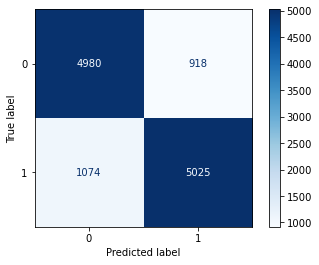

In [8]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Gaussian Naive Bayes

Cross Validation accuracy score: 0.6974498266003581

Base Model Accuracy: 0.699

METRICS:
Accuracy score:
0.6993415020421773

Recall score:
0.6993415020421773

Precison score:
0.7000395143938295

F1-score:
0.6992899399143353

MCC score:
0.3994530646774577

Confusion matrix:
[[4238 1660]
 [1947 4152]]

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      5898
           1       0.71      0.68      0.70      6099

    accuracy                           0.70     11997
   macro avg       0.70      0.70      0.70     11997
weighted avg       0.70      0.70      0.70     11997




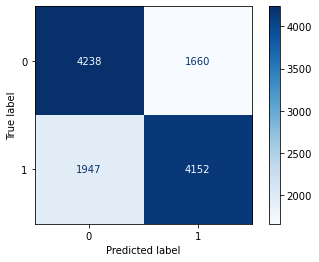

In [9]:
ml(nb, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors

Cross Validation accuracy score: 0.7908335721410978

Base Model Accuracy: 0.803

{'leaf_size': 40, 'n_neighbors': 14, 'p': 1, 'weights': 'distance'}

Optimized Model Accuracy: 0.818

Optimized model improved 1.931% over base model.

METRICS:
Accuracy score:
0.8184546136534133

Recall score:
0.8184546136534133

Precison score:
0.8205334519597219

F1-score:
0.818307876133188

MCC score:
0.6391150856676271

Confusion matrix:
[[5037  861]
 [1317 4782]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      5898
           1       0.85      0.78      0.81      6099

    accuracy                           0.82     11997
   macro avg       0.82      0.82      0.82     11997
weighted avg       0.82      0.82      0.82     11997




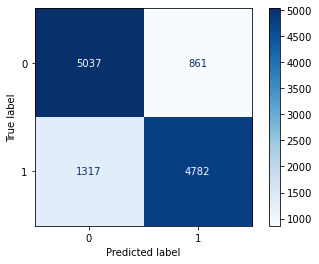

In [10]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation accuracy score: 0.7661835443615492

Base Model Accuracy: 0.778

METRICS:
Accuracy score:
0.7782779028090356

Recall score:
0.7782779028090356

Precison score:
0.7806161984214754

F1-score:
0.7780349731617424

MCC score:
0.5590821478341618

Confusion matrix:
[[4823 1075]
 [1585 4514]]

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      5898
           1       0.81      0.74      0.77      6099

    accuracy                           0.78     11997
   macro avg       0.78      0.78      0.78     11997
weighted avg       0.78      0.78      0.78     11997




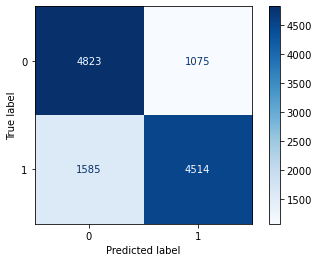

In [11]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network

Cross Validation accuracy score: 0.801800773258584

Base Model Accuracy: 0.804

{'activation': 'relu', 'learning_rate': 'adaptive'}

Optimized Model Accuracy: 0.812

Optimized model improved 0.984% over base model.

METRICS:
Accuracy score:
0.8122864049345669

Recall score:
0.8122864049345669

Precison score:
0.8122951404224513

F1-score:
0.8122598501319745

MCC score:
0.6244373052175678

Confusion matrix:
[[4735 1163]
 [1089 5010]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      5898
           1       0.81      0.82      0.82      6099

    accuracy                           0.81     11997
   macro avg       0.81      0.81      0.81     11997
weighted avg       0.81      0.81      0.81     11997




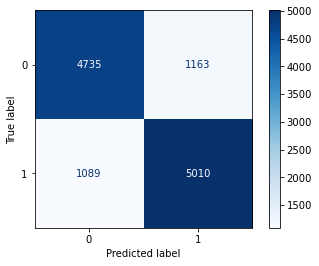

In [12]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

## Descriptors without feature selection

In [13]:
descriptors = pd.read_csv('../dataset/binary_class/descriptors_binary.csv', sep=',')

descriptors_data_b = descriptors.drop("activity", axis=1)
descriptors_data_b = StandardScaler().fit_transform(descriptors_data_b)
descriptors_label_b = descriptors["activity"]

### Random Forest

Cross Validation accuracy score: 0.8128043458993117

Base Model Accuracy: 0.822

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 225}

Optimized Model Accuracy: 0.833

Optimized model improved 1.369% over base model.

METRICS:
Accuracy score:
0.8332083020755189

Recall score:
0.8332083020755189

Precison score:
0.8333791912157449

F1-score:
0.833219826350048

MCC score:
0.6665465217740154

Confusion matrix:
[[4954  944]
 [1057 5042]]

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      5898
           1       0.84      0.83      0.83      6099

    accuracy                           0.83     11997
   macro avg       0.83      0.83      0.83     11997
weighted avg       0.83      0.83      0.83     11997




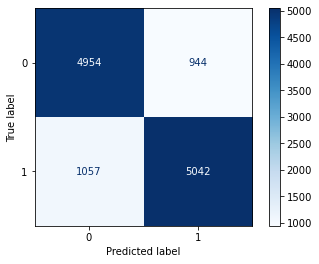

In [14]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

comparaçao

## Fingerprints

In [15]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_b, fingerprint_label_b, test_size=0.3)

### Random Forest

Cross Validation accuracy score: 0.8020220971679919

Base Model Accuracy: 0.817

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}

Optimized Model Accuracy: 0.822

Optimized model improved 0.530% over base model.

METRICS:
Accuracy score:
0.8217054263565892

Recall score:
0.8217054263565892

Precison score:
0.8218071913059133

F1-score:
0.8216957288283242

MCC score:
0.6435176949154559

Confusion matrix:
[[4967 1018]
 [1121 4891]]

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      5985
           1       0.83      0.81      0.82      6012

    accuracy                           0.82     11997
   macro avg       0.82      0.82      0.82     11997
weighted avg       0.82      0.82      0.82     11997




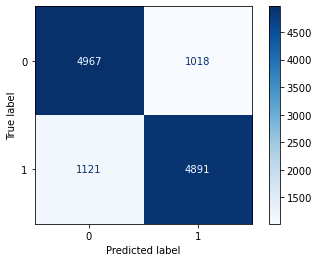

In [16]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Gaussian Naive Bayes

Cross Validation accuracy score: 0.6604507542018203

Base Model Accuracy: 0.668

METRICS:
Accuracy score:
0.6675002083854297

Recall score:
0.6675002083854297

Precison score:
0.6675463030714901

F1-score:
0.6674881489375273

MCC score:
0.3350539945629327

Confusion matrix:
[[4034 1951]
 [2038 3974]]

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      5985
           1       0.67      0.66      0.67      6012

    accuracy                           0.67     11997
   macro avg       0.67      0.67      0.67     11997
weighted avg       0.67      0.67      0.67     11997




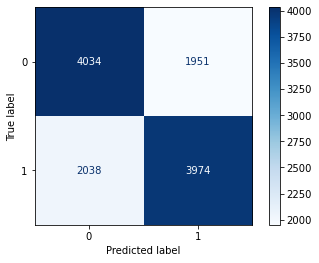

In [17]:
ml(nb, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors

Cross Validation accuracy score: 0.7722646460945501

Base Model Accuracy: 0.787

{'leaf_size': 30, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

Optimized Model Accuracy: 0.802

Optimized model improved 1.895% over base model.

METRICS:
Accuracy score:
0.8022839043094107

Recall score:
0.8022839043094107

Precison score:
0.8071382682772271

F1-score:
0.8015362919977285

MCC score:
0.6094569225849665

Confusion matrix:
[[5174  811]
 [1561 4451]]

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      5985
           1       0.85      0.74      0.79      6012

    accuracy                           0.80     11997
   macro avg       0.81      0.80      0.80     11997
weighted avg       0.81      0.80      0.80     11997




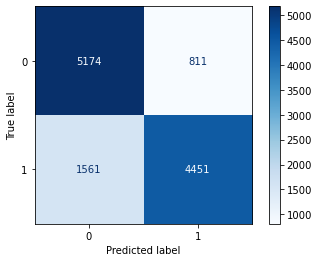

In [18]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation accuracy score: 0.7473653521423881

Base Model Accuracy: 0.758

METRICS:
Accuracy score:
0.7576060681837126

Recall score:
0.7576060681837126

Precison score:
0.7583423507867391

F1-score:
0.7574542105650359

MCC score:
0.5159740349292274

Confusion matrix:
[[4688 1297]
 [1611 4401]]

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      5985
           1       0.77      0.73      0.75      6012

    accuracy                           0.76     11997
   macro avg       0.76      0.76      0.76     11997
weighted avg       0.76      0.76      0.76     11997




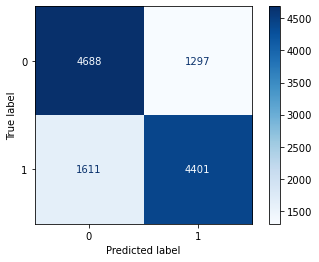

In [19]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network

Cross Validation accuracy score: 0.7731577903240391

Base Model Accuracy: 0.784

{'activation': 'tanh', 'learning_rate': 'constant'}

Optimized Model Accuracy: 0.790

Optimized model improved 0.723% over base model.

METRICS:
Accuracy score:
0.7898641326998417

Recall score:
0.7898641326998417

Precison score:
0.7899206441298807

F1-score:
0.789858134879355

MCC score:
0.5797888745021978

Confusion matrix:
[[4764 1221]
 [1300 4712]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      5985
           1       0.79      0.78      0.79      6012

    accuracy                           0.79     11997
   macro avg       0.79      0.79      0.79     11997
weighted avg       0.79      0.79      0.79     11997




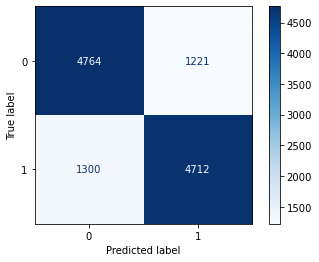

In [20]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

## Comparation

TABLE HERE

# Multiclass

### Load data

In [21]:
descriptors = pd.read_csv('../dataset/multiclass/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/multiclass/rdk_fs.csv', sep=',')

descriptors_data_m = descriptors.drop("Activity at 46.23 uM", axis=1)
descriptors_label_m = descriptors["Activity at 46.23 uM"]
fingerprint_data_m = fingerprint.drop("Activity at 46.23 uM", axis=1)
fingerprint_label_m = fingerprint["Activity at 46.23 uM"]

## Descriptors

In [22]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_m, descriptors_label_m, test_size=0.3)

### Random Forest Classifier

Cross Validation accuracy score: 0.5715000976175435

Base Model Accuracy: 0.570

{'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 250}

Optimized Model Accuracy: 0.574

Optimized model improved 0.732% over base model.

METRICS:
Accuracy score:
0.5740632562797297

Recall score:
0.5740632562797297

Precison score:
0.5291462954388862

F1-score:
0.5148369343451838

MCC score:
0.3561289916114144

Confusion matrix:
[[ 125 1175  288    2]
 [ 185 3321  885    9]
 [  15  862 3333  158]
 [   1  184 1340  100]]

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.08      0.13      1590
           1       0.60      0.75      0.67      4400
           2       0.57      0.76      0.65      4368
           3       0.37      0.06      0.11      1625

    accuracy                           0.57     11983
   macro avg       0.48      0.41      0.39     11983
weighted avg       0.53      0.57      0.51     11983



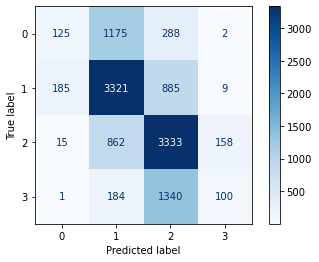

In [23]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Gaussian Naive Bayes

Cross Validation accuracy score: 0.3963088670249474

Base Model Accuracy: 0.395

METRICS:
Accuracy score:
0.3949762163064341

Recall score:
0.3949762163064341

Precison score:
0.4081772909330985

F1-score:
0.38502576342132944

MCC score:
0.15806469022294425

Confusion matrix:
[[ 226  865  277  222]
 [ 422 2548  884  546]
 [ 123 1287 1161 1797]
 [  36  371  420  798]]

Classification report:
              precision    recall  f1-score   support

           0       0.28      0.14      0.19      1590
           1       0.50      0.58      0.54      4400
           2       0.42      0.27      0.33      4368
           3       0.24      0.49      0.32      1625

    accuracy                           0.39     11983
   macro avg       0.36      0.37      0.34     11983
weighted avg       0.41      0.39      0.39     11983




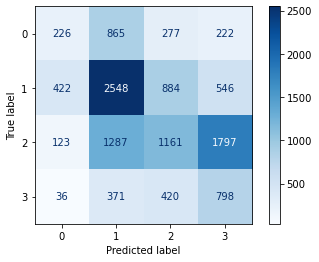

In [24]:
ml(nb, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors Classifier

Cross Validation accuracy score: 0.5138061336057924

Base Model Accuracy: 0.518

{'leaf_size': 40, 'n_neighbors': 16, 'p': 1, 'weights': 'distance'}

Optimized Model Accuracy: 0.557

Optimized model improved 7.502% over base model.

METRICS:
Accuracy score:
0.5572894934490529

Recall score:
0.5572894934490529

Precison score:
0.5090601225862557

F1-score:
0.5073424955007781

MCC score:
0.33191560243006396

Confusion matrix:
[[ 144 1118  316   12]
 [ 230 3099 1030   41]
 [  32  778 3303  255]
 [   6  184 1303  132]]

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.09      0.14      1590
           1       0.60      0.70      0.65      4400
           2       0.55      0.76      0.64      4368
           3       0.30      0.08      0.13      1625

    accuracy                           0.56     11983
   macro avg       0.45      0.41      0.39     11983
weighted avg       0.51      0.56      0.51     11983




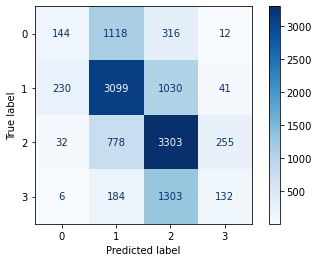

In [25]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation accuracy score: 0.4986765466367493

Base Model Accuracy: 0.502

METRICS:
Accuracy score:
0.5021280146874739

Recall score:
0.5021280146874739

Precison score:
0.4846674598295465

F1-score:
0.48460307168278943

MCC score:
0.26789169061659784

Confusion matrix:
[[ 187 1016  293   94]
 [ 283 2968  918  231]
 [  62  980 2402  924]
 [  20  241  904  460]]

Classification report:
              precision    recall  f1-score   support

           0       0.34      0.12      0.17      1590
           1       0.57      0.67      0.62      4400
           2       0.53      0.55      0.54      4368
           3       0.27      0.28      0.28      1625

    accuracy                           0.50     11983
   macro avg       0.43      0.41      0.40     11983
weighted avg       0.48      0.50      0.48     11983




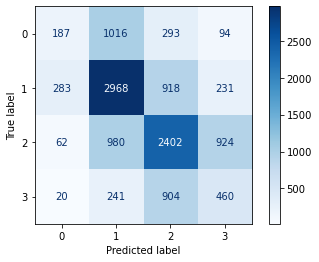

In [26]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network Classifier

Cross Validation accuracy score: 0.5560483855491236

Base Model Accuracy: 0.555

{'activation': 'tanh', 'learning_rate': 'constant'}

Optimized Model Accuracy: 0.550

Optimized model improved -0.947% over base model.

METRICS:
Accuracy score:
0.5554535592088793

Recall score:
0.5554535592088793

Precison score:
0.5109195252076658

F1-score:
0.48600130430570093

MCC score:
0.3234573443723524

Confusion matrix:
[[  57 1197  335    1]
 [  71 3334  990    5]
 [  16 1056 3205   91]
 [  10  232 1323   60]]

Classification report:
              precision    recall  f1-score   support

           0       0.37      0.04      0.07      1590
           1       0.57      0.76      0.65      4400
           2       0.55      0.73      0.63      4368
           3       0.38      0.04      0.07      1625

    accuracy                           0.56     11983
   macro avg       0.47      0.39      0.35     11983
weighted avg       0.51      0.56      0.49     11983




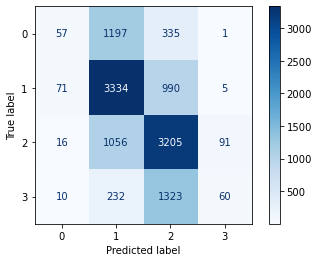

In [27]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

### Undersampling

Cross Validation accuracy score: 0.4577597840755735

Base Model Accuracy: 0.371

{'bootstrap': True, 'criterion': 'entropy', 'max_features': None, 'n_estimators': 100}

Optimized Model Accuracy: 0.363

Optimized model improved -2.359% over base model.

METRICS:
Accuracy score:
0.3714428774096637

Recall score:
0.3714428774096637

Precison score:
0.4745742402183311

F1-score:
0.3822463410912073

MCC score:
0.19910127211356274

Confusion matrix:
[[ 818  497  120  155]
 [2023 1440  467  470]
 [ 599  462 1290 2017]
 [ 124   98  500  903]]

Classification report:
              precision    recall  f1-score   support

           0       0.23      0.51      0.32      1590
           1       0.58      0.33      0.42      4400
           2       0.54      0.30      0.38      4368
           3       0.25      0.56      0.35      1625

    accuracy                           0.37     11983
   macro avg       0.40      0.42      0.37     11983
weighted avg       0.47      0.37      0.38     11983



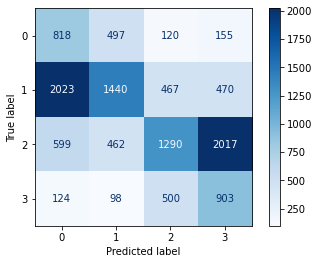

In [28]:
ml(rf, data_train, data_test, label_train, label_test, params_rf, sampling=True)

## Fingerprints

In [29]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_m, fingerprint_label_m, test_size=0.3)

### Random Forest Classifier

Cross Validation accuracy score: 0.5420629580700027

Base Model Accuracy: 0.557

{'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 225}

Optimized Model Accuracy: 0.558

Optimized model improved 0.045% over base model.

METRICS:
Accuracy score:
0.5577067512309104

Recall score:
0.5577067512309104

Precison score:
0.5213832635362105

F1-score:
0.5244868758561237

MCC score:
0.3380502035895744

Confusion matrix:
[[ 250 1070  308   14]
 [ 365 3058  889   42]
 [  42  781 3148  434]
 [  11  201 1143  227]]

Classification report:
              precision    recall  f1-score   support

           0       0.37      0.15      0.22      1642
           1       0.60      0.70      0.65      4354
           2       0.57      0.71      0.64      4405
           3       0.32      0.14      0.20      1582

    accuracy                           0.56     11983
   macro avg       0.47      0.43      0.42     11983
weighted avg       0.52      0.56      0.52     11983




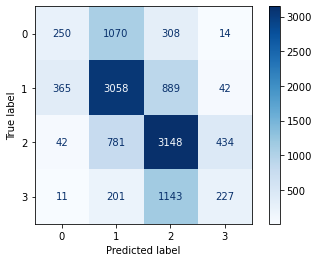

In [30]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Gaussian Naive Bayes

Cross Validation accuracy score: 0.3420132857092778

Base Model Accuracy: 0.349

METRICS:
Accuracy score:
0.3493282149712092

Recall score:
0.3493282149712092

Precison score:
0.3941568101652765

F1-score:
0.35304170081988057

MCC score:
0.13071815680466617

Confusion matrix:
[[ 459  654  261  268]
 [1035 1880  771  668]
 [ 468 1076 1050 1811]
 [ 153  306  326  797]]

Classification report:
              precision    recall  f1-score   support

           0       0.22      0.28      0.24      1642
           1       0.48      0.43      0.45      4354
           2       0.44      0.24      0.31      4405
           3       0.22      0.50      0.31      1582

    accuracy                           0.35     11983
   macro avg       0.34      0.36      0.33     11983
weighted avg       0.39      0.35      0.35     11983




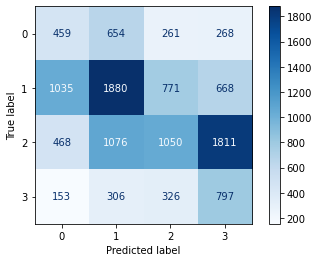

In [31]:
ml(nb, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors Classifier

Cross Validation accuracy score: 0.5108018737450772

Base Model Accuracy: 0.524

{'leaf_size': 20, 'n_neighbors': 16, 'p': 1, 'weights': 'distance'}

Optimized Model Accuracy: 0.550

Optimized model improved 5.099% over base model.

METRICS:
Accuracy score:
0.5504464658265876

Recall score:
0.5504464658265876

Precison score:
0.5154397786501101

F1-score:
0.5135397248618475

MCC score:
0.32709517359641876

Confusion matrix:
[[ 229  981  416   16]
 [ 310 2815 1163   66]
 [  52  626 3361  366]
 [  13  150 1228  191]]

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.14      0.20      1642
           1       0.62      0.65      0.63      4354
           2       0.54      0.76      0.64      4405
           3       0.30      0.12      0.17      1582

    accuracy                           0.55     11983
   macro avg       0.46      0.42      0.41     11983
weighted avg       0.52      0.55      0.51     11983




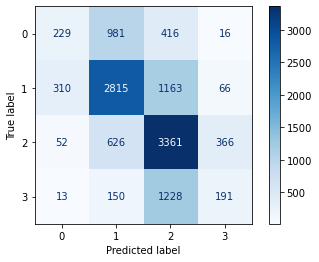

In [32]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation accuracy score: 0.472315671082869

Base Model Accuracy: 0.486

METRICS:
Accuracy score:
0.4855211549695402

Recall score:
0.4855211549695402

Precison score:
0.4843526515654967

F1-score:
0.4815672590687241

MCC score:
0.2602581483766855

Confusion matrix:
[[ 289  952  265  136]
 [ 474 2696  853  331]
 [ 142  820 2308 1135]
 [  58  192  807  525]]

Classification report:
              precision    recall  f1-score   support

           0       0.30      0.18      0.22      1642
           1       0.58      0.62      0.60      4354
           2       0.55      0.52      0.53      4405
           3       0.25      0.33      0.28      1582

    accuracy                           0.49     11983
   macro avg       0.42      0.41      0.41     11983
weighted avg       0.48      0.49      0.48     11983




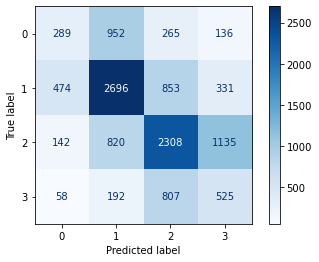

In [33]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network Classifier

Cross Validation accuracy score: 0.5351954999208057

Base Model Accuracy: 0.552

{'activation': 'relu', 'learning_rate': 'constant'}

Optimized Model Accuracy: 0.539

Optimized model improved -2.372% over base model.

METRICS:
Accuracy score:
0.5524493031795042

Recall score:
0.5524493031795042

Precison score:
0.4907678385132045

F1-score:
0.4814870763076892

MCC score:
0.3190782653712013

Confusion matrix:
[[  36 1224  371   11]
 [  49 3255 1028   22]
 [  18 1006 3269  112]
 [  11  288 1223   60]]

Classification report:
              precision    recall  f1-score   support

           0       0.32      0.02      0.04      1642
           1       0.56      0.75      0.64      4354
           2       0.55      0.74      0.64      4405
           3       0.29      0.04      0.07      1582

    accuracy                           0.55     11983
   macro avg       0.43      0.39      0.35     11983
weighted avg       0.49      0.55      0.48     11983




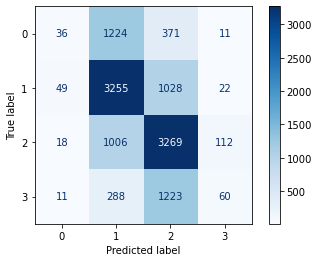

In [34]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

## Regression

### Load data

In [35]:
descriptors = pd.read_csv('../dataset/regression/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/regression/rdk_fs.csv', sep=',')

descriptors_data_r = descriptors.drop("Activity at 46.23 uM", axis=1)
descriptors_label_r = descriptors["Activity at 46.23 uM"]
fingerprint_data_r = fingerprint.drop("Activity at 46.23 uM", axis=1)
fingerprint_label_r = fingerprint["Activity at 46.23 uM"]

### Models

In [36]:
rf = RandomForestRegressor(n_jobs=4)
lr = LinearRegression()
knn = KNeighborsRegressor(n_jobs=4)
voting = VotingRegressor(estimators=[('Random Forest', rf), ('Linear Regression', lr), ('KNN', knn)], n_jobs=4)
nn = MLPRegressor(early_stopping=True)

## Descriptors

In [37]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_r, descriptors_label_r, test_size=0.3)

### Random Forest Regressor

In [38]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

### Linear Regression

In [ ]:
ml(lr, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors Regressor

In [ ]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Regressor

In [ ]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network Regressor

In [ ]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)

## Fingerprints

In [ ]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_r, fingerprint_label_r, test_size=0.3)

### Random Forest Regressor

In [ ]:
ml(rf, data_train, data_test, label_train, label_test, params_rf)

### Linear Regression

In [ ]:
ml(lr, data_train, data_test, label_train, label_test, None)

### K Nearest Neighbors Regressor

In [ ]:
ml(knn, data_train, data_test, label_train, label_test, params_knn)

### Voting Regressor

In [ ]:
ml(voting, data_train, data_test, label_train, label_test, None)

### Neural Network Regressor

In [ ]:
ml(nn, data_train, data_test, label_train, label_test, params_nn)